In [10]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 2)

coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

# hamiltonian_acc = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

$$
H = 1 * (Z \otimes Z)
$$

In [11]:
# Global paras 
Tau_global = 1e-09   # Dephase tau
Paras_global, Phi_global, Gamma_ps  = np_.array([0] * 3), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

$$
\rho_{After-Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$


$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [12]:
@qml.qnode(dev)
def circuit_1(paras):
    """ Include the entangler stage and the phase accumulator stage for a 2-qubit system.
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2] as a paramters.
        Set 'phi' from the 'Cost_function' using global variables.
        Dephase_factors = fixed as Tau_global.

    Returns:
        qml.density_matrix: Density matrix of qnode
    """
    
    # Call global phi
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Assign paras
    theta_init, tau_1, tau_2, theta_x = paras[0], paras[1], paras[2], paras[3]
    
    # Calculate dephase factor with fixed tau
    # gamma_dephase_in = Dephase_factor(Tau_global)  
    # print(gamma_dephase_in, Dephase_global)
        
    # Stage_1: RY for pi/2
    # qml.Hadamard(wires=0)
    # qml.Hadamard(wires=1)
    qml.RY(np.pi / 2, wires = 0)
    qml.RY(np.pi / 2, wires = 1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    # qml.PhaseDamping(gamma_dephase_in, wires = 0)
    # qml.PhaseDamping(gamma_dephase_in, wires = 1)

    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi / 2, wires = 0)    
    qml.RY(-np.pi / 2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)
    # qml.PhaseDamping(gamma_dephase_in, wires = 0)
    # qml.PhaseDamping(gamma_dephase_in, wires = 1)

    qml.RY(np.pi / 2, wires = 0)    
    qml.RY(np.pi / 2, wires = 1) 
    # qml.Hadamard(wires=0)
    # qml.Hadamard(wires=1)
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    # qml.PhaseDamping(gamma_dephase_in, wires = 0)
    # qml.PhaseDamping(gamma_dephase_in, wires = 1)
    
    qml.RY(theta_x, wires = 0)   # 8 4dd 3 2ss
    qml.RY(theta_x, wires = 1)
    # qml.RY(-np.pi/(2 + 1e-6), wires = 0)
    # qml.RY(-np.pi/(2 + 1e-6), wires = 1)
    
    return qml.density_matrix(wires=[0, 1])

@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = [0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    
    Numerator = np.kron(K, np.eye(2)) @ density_matrix @ np.kron(K, np.eye(2)).conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1])  

$$ K =  \begin{bmatrix}
\sqrt{1-\gamma} & 0 \\
0 & 1 
\end{bmatrix}  $$


$$
\rho_{ps} = 
\frac{(K \otimes I) \rho (K^{\dagger} \otimes I ^{\dagger})}

{Tr[(K \otimes I) \rho (K^{\dagger} \otimes I ^{\dagger})]}
$$

![Alt text](image-1.png)

In [13]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [14]:
# == Check for maximum tau <-> gamma ==
tau_test = 18.7

print('Gamma =', Dephase_factor(tau_test), ', [ at tau =',tau_test,']' )

Gamma = 0.9999999999999999 , [ at tau = 18.7 ]


In [15]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * len(paras)
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

Data = 

array([ [PHI_0, CFI_0, theta_0, tau_1, tau_2, tau_d1, tau_d2, tau_d3], 

...

In [16]:
# # == Fixed to gamma_ps = 0.8 ==

# # == Sweep for 0 ~ pi*3 == 
# Sweep_data = np_.array([1e-4, np.pi * 1 + 1e-4, 1])

# Para_init = np_.zeros(3)
# Para_init[:3] = random.uniform(-1, 1)
# # Para_init[2] = -1e-1

# Gamma_ps_preset = 0.8
# Set_Iterations = 3

# Optimized_Result = BFGS(Sweep_data, Para_init, Gamma_ps_preset, Set_Iterations)

In [17]:
# plt.plot(Optimized_Result[0][:,0], Optimized_Result[3][:,1])

# plt.title(f'L-BFGS-B at $\gamma_{{ps}}$ = {Gamma_ps_preset}')
# plt.xlabel('Time')
# plt.ylabel('CFI')
# plt.legend()
# plt.grid() 

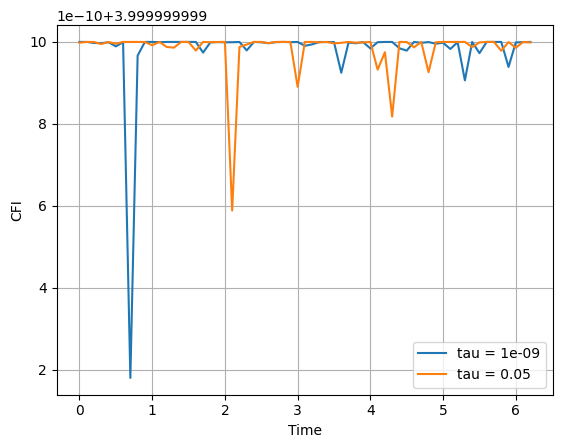

In [18]:
Tau_PLOT = 1e-09, 5e-2

for i in range(len(Tau_PLOT)):
    Tau_global = Tau_PLOT[i]
    
    Sweep_data = np_.array([1e-4, np.pi * 2 + 1e-4, 1e-1])

    Para_init = np_.zeros(4)
    Para_init[:4] = random.uniform(0, 1)

    Gamma_ps_preset = 0
    Set_Iterations = 2

    Optimized_Result = BFGS(Sweep_data, Para_init, Gamma_ps_preset, Set_Iterations)
    
    plt.plot(Optimized_Result[0, :, 0], Optimized_Result[1][:, 1], label = f'tau = {Tau_PLOT[i]}')
    

plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

In [19]:
# Optimized_Result[:, 0]

# layer = 0 & test_case = 3.01000000e-01
Current_Layer = 1
Optimized_Result[Current_Layer][:, 2 : ]

# Optimized_Result[0][:,:]

array([[-3.16313834e-07,  6.43248834e-01,  5.83335395e-01,
         1.57079594e+00],
       [ 2.90824218e-08,  3.86277179e-01,  5.83335411e-01,
         1.57079647e+00],
       [-3.96437807e-01, -4.55869168e-08,  5.83335398e-01,
         1.57079620e+00],
       [-6.31815904e-01,  2.32334349e-07,  5.83335411e-01,
         1.57079517e+00],
       [-4.38857555e-07,  5.43996745e-02,  5.83335258e-01,
         1.57079605e+00],
       [-7.16327277e-09, -4.49162250e-01,  5.83335402e-01,
         1.57079481e+00],
       [-3.82226956e-08, -2.74149969e-01,  5.83336344e-01,
         1.57079630e+00],
       [ 2.18994082e-01,  1.30307295e-07,  5.83335394e-01,
         1.57079619e+00],
       [ 4.45221017e-01, -2.55584088e-08,  5.83335447e-01,
         1.57079625e+00],
       [ 6.97906304e-01, -1.02182875e-07,  5.83335342e-01,
         1.57079619e+00],
       [ 9.28379591e-01, -6.73416164e-07,  5.83335351e-01,
         1.57079624e+00],
       [ 2.25313828e+00, -3.14159265e+00,  5.83335307e-01,
      

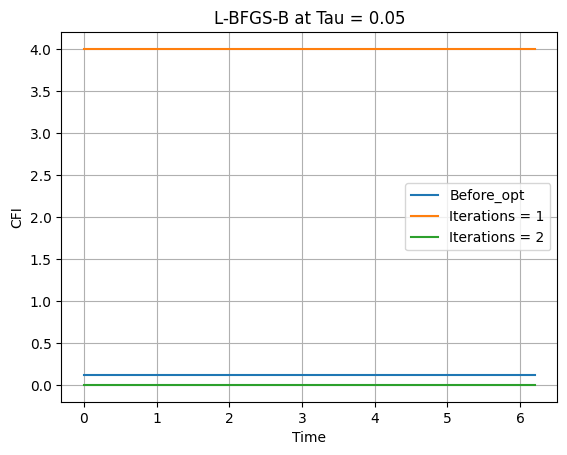

In [20]:
plt.plot(Optimized_Result[0, : ,0], Optimized_Result[0, : ,1], label = 'Before_opt')
for i in range(1, Set_Iterations + 1):
    plt.plot(Optimized_Result[0, :, 0], Optimized_Result[i, :, 1], label = f'Iterations = {i}')
    
plt.title(f'L-BFGS-B at Tau = {Tau_global}')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

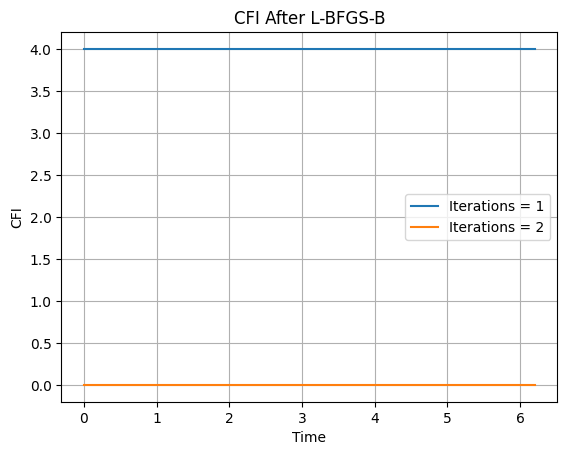

In [21]:
Target_Layer =  1,2
plt.plot(Optimized_Result[Target_Layer[0], :, 0], Optimized_Result[Target_Layer[0], :, 1], 
         label = f'Iterations = {Target_Layer[0]}')

plt.plot(Optimized_Result[Target_Layer[1], :, 0], Optimized_Result[Target_Layer[1], :, 1], 
         label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

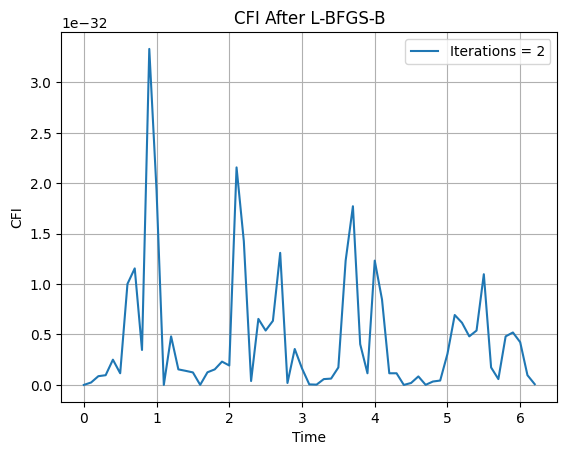

In [22]:
plt.plot(Optimized_Result[1, :, 0], Optimized_Result[Target_Layer[1], :, 1], 
         label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

In [23]:
# == Check if optimized results are smaller than the past ==

Flag, Count = 0, 0
Index = np_.zeros(len(Optimized_Result[0, :, 1]))

for i in range(len(Optimized_Result[2, :, 1])):
    Flag = 0 if Optimized_Result[3, i, 1] > Optimized_Result[1, i, 1]  else 1
    if Flag == 1:
        
        Index[Count] = i
        print(i)
        Count = Count + 1

for i in range(len(Index)):
    print(Optimized_Result[1, int(Index[i]), 1], '  ', Optimized_Result[3, int(Index[i]), 1])

IndexError: index 3 is out of bounds for axis 0 with size 3

Each row of 6-paras => Corresponds to phi

func(phi, paras, gamma_ps)
=> Implement on SLSQP 

Data = [[phi, CFI, theata_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3] ... N]

In [ ]:
# Bad case after optimization

Num_of_Layer = 1
Condition = np_.where(Optimized_Result[Num_of_Layer][:, 1] < 98)

print('Index:\n', Condition[0])

print('\n')

Optimized_Result[Num_of_Layer, Condition[0], 1]

print('PHI:\n', Optimized_Result[Num_of_Layer, Condition[0], 0], 
      '\n\nCFI\n', Optimized_Result[Num_of_Layer, Condition[0], 1], 
      '\n\nParas\n', Optimized_Result[Num_of_Layer, Condition[0], 2 : ])

Index:
 [0 1 2 3 4 5 6]


PHI:
 [1.0000e-04 1.0001e+00 2.0001e+00 3.0001e+00 4.0001e+00 5.0001e+00
 6.0001e+00] 

CFI
 [3.35373918e-17 1.82942489e-09 2.13587807e-09 5.13706056e-11
 1.48002692e-09 2.37531952e-09 2.01519598e-10] 

Paras
 [[0.44752768 0.44752768 0.44752768]
 [0.44752768 0.44752768 0.44752768]
 [0.44752768 0.44752768 0.44752768]
 [0.44752768 0.44752768 0.44752768]
 [0.44752768 0.44752768 0.44752768]
 [0.44752768 0.44752768 0.44752768]
 [0.44752768 0.44752768 0.44752768]]
